In [9]:
from langchain_openai import ChatOpenAI

_llm = ChatOpenAI(
    base_url="http://58.34.49.226:11046/v1",
    model="qwen2.5:7b",
    api_key="ollama"
)

In [10]:
from planner import Planner
from executor import Executor
from gatherer import Gatherer

_planner = Planner(_llm)
_executor = Executor(_llm)
_gatherer = Gatherer(_llm)

In [11]:
from typing_extensions import TypedDict
from typing import List,Annotated
from operator import add

class PlanState(TypedDict):
    query:str
    task_list:List[str]
    infos:Annotated[List[str],add]
    result:str

In [12]:
def _planner_node(state):
    _rt = _planner(state)
    return _rt

In [13]:
def _executor_node(state):
    _infos = state.get("infos",[])
    _task_index = len(_infos)
    _task = state["task_list"][_task_index]

    _rt = _executor({
        "infos":_infos,
        "task":_task
    })

    return {"infos":[_rt]}

In [14]:
def _gatherer_node(state):
    _infos = state["infos"]
    _query = state["query"]

    _rt = _gatherer({
        "infos":_infos,
        "query":_query
    })

    return {"result":_rt}

In [15]:
def _executor_router(state):
    _task_len = len(state["task_list"])
    _infos = len(state["infos"])

    if _task_len == _infos:
        return "_gatherer_node"
    else:
        return "_executor_node"

In [16]:
from langgraph.graph import StateGraph,START,END
_builder = StateGraph(PlanState)

_builder.add_node("_planner_node",_planner_node)
_builder.add_node("_executor_node",_executor_node)
_builder.add_node("_gatherer_node",_gatherer_node)

_builder.add_edge(START,"_planner_node")
_builder.add_edge("_planner_node","_executor_node")
_builder.add_conditional_edges("_executor_node",_executor_router,{"_gatherer_node":"_gatherer_node","_executor_node":"_executor_node"})
_builder.add_edge("_gatherer_node",END)

_graph = _builder.compile()


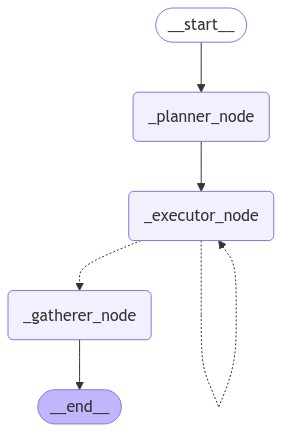

In [17]:
from IPython.display import display,Image

display(Image(_graph.get_graph().draw_mermaid_png()))

In [20]:
_rt = _graph.invoke({"query":"2024年法国巴黎奥运会女子10米跳水冠军的家乡?"})
_rt["result"]

调用了工具
调用了工具


'根据提供的信息，目前无法准确预测2024年法国巴黎奥运会女子10米跳水冠军的具体身份和家乡。但是我们知道陈芋汐出生于中国上海市，并在该地开始了她的体育生涯并取得了优异成绩。因此，如果陈芋汐能够获得金牌，她的家乡就是上海。不过这只是根据现有信息的一个可能情况，实际情况可能会有所不同。'